# Timeseries data

In this example we calculate the data of a wind farm with 67 turbines in a time series containing 8000 uniform inflow states.

The required imports are:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

First, we create the `states`. The `data_source` can be any csv-type file (or `pandas` readable equivalent), or a `pandas.DataFrame` object. If it is a file path, then it will first be searched in the file system, and if not found, in the static data. If it is also not found there, an error showing the available static data file names is displayed.

In this example the static data file `timeseries_8000.csv.gz` will be used, with content
```
Time,ws,wd,ti
2017-01-01 00:00:00,15.62,244.06,0.0504
2017-01-01 00:30:00,15.99,243.03,0.0514
2017-01-01 01:00:00,16.31,243.01,0.0522
2017-01-01 01:30:00,16.33,241.26,0.0523
...
```
Notice the column names, and how they appear in the `Timeseries` constructor:

In [2]:
states = foxes.input.states.Timeseries(
    data_source="timeseries_8000.csv.gz",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.TI: "ti"},
    fixed_vars={FV.RHO: 1.225},
)

We can visualize the wind distribution via the `StatesRosePlotOutput`. Here we display the ambient wind speed in a wind rose with 16 wind direction sectors and 5 wind speed bins: 

Selecting 'DefaultEngine(n_procs=16, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8000 states for 1 turbines
SingleChunkEngine: Running single chunk calculation for 8000 states


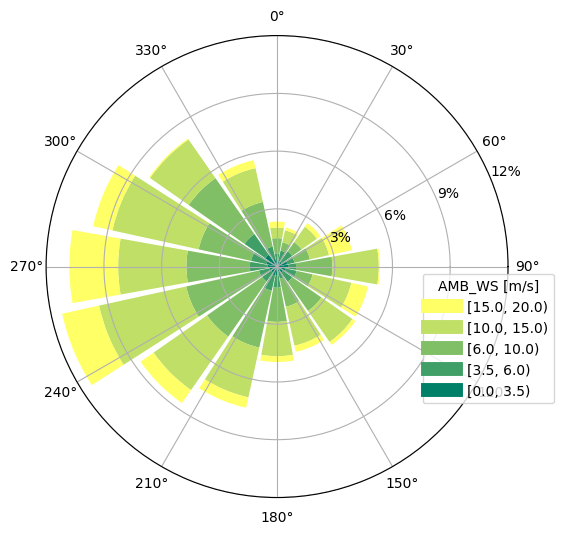

In [3]:
o = foxes.output.StatesRosePlotOutput(states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

For the time series with uniform data, any choice of the `point` argument will produce the same figure.

Next, we create the example wind farm with 67 turbines from static data. The file `test_farm_67.csv` has the following structure:
```
index,label,x,y
0,T0,101872.70,1004753.57
1,T1,103659.97,1002993.29
2,T2,100780.09,1000779.97
3,T3,100290.42,1004330.88
...
```
For more options, check the API section `foxes.input.farm_layout`. 

We consider two turbine models in this example: the wind turbine type `NREL5MW` and the turbine model `kTI_02`, both from the default model book. The latter model adds the variable `k` for each state and turbine, calculated as `k = kTI * TI`, with constant `kTI = 0.2`. The parameter `k` will later be used by the wake model.

In [4]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_from_file(
    farm, "test_farm_67.csv", turbine_models=["NREL5MW"], verbosity=0
)

Next, we create the `algorithm`, with further model selections. In particular, two wake models are invoked, the model `Bastankhah_quadratic` for wind speed deficits and the model `CrespoHernandez_max` for turbulence intensity:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_quadratic_ka02", "CrespoHernandez_max_ka04"],
    verbosity=0,
)

Also notice the `chunks` parameter, specifying that always 1000 states should be considered in vectorized form during calculations. The progress is automatically visualized when invoking the `DaskRunner`:

In [6]:
farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print("\n", fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8000 states for 67 turbines


ProcessEngine: Computing 16 chunks using 16 processes


  0%|                                                                                                                                                    | 0/16 [00:00<?, ?it/s]

  6%|████████▊                                                                                                                                   | 1/16 [00:04<01:04,  4.30s/it]

 25%|███████████████████████████████████                                                                                                         | 4/16 [00:04<00:11,  1.02it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                              | 7/16 [00:05<00:04,  2.09it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 10/16 [00:05<00:01,  3.30it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 13/16 [00:05<00:00,  4.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.93it/s]


                                  WD  AMB_REWS       REWS    AMB_P            P
state               turbine                                                   
2017-01-01 00:00:00 0        244.06     15.62  15.610500  5000.00  5000.000000
                    1        244.06     15.62  14.012903  5000.00  5000.000000
                    2        244.06     15.62  15.021033  5000.00  5000.000000
                    3        244.06     15.62  15.560020  5000.00  5000.000000
                    4        244.06     15.62  14.564008  5000.00  5000.000000
...                             ...       ...        ...      ...          ...
2017-06-16 15:30:00 62       299.19     11.70   8.145984  4868.75  1880.222715
                    63       299.19     11.70  11.490711  4868.75  4777.186188
                    64       299.19     11.70  11.700000  4868.75  4868.750000
                    65       299.19     11.70  11.642754  4868.75  4843.705093
                    66       299.19     11.70   8.

Let's evaluate the results:

In [7]:
# add capacity and efficiency to farm_results:
o = foxes.output.FarmResultsEval(farm_results)
o.add_capacity(algo)
o.add_capacity(algo, ambient=True)
o.add_efficiency()

# print results by turbine:
turbine_results = o.reduce_states(
    {
        FV.AMB_P: "weights",
        FV.P: "weights",
        FV.AMB_CAP: "weights",
        FV.CAP: "weights",
    }
)
turbine_results[FV.AMB_YLD] = o.calc_turbine_yield(algo=algo, annual=True, ambient=True)
turbine_results[FV.YLD] = o.calc_turbine_yield(algo=algo, annual=True)
turbine_results[FV.EFF] = turbine_results[FV.P] / turbine_results[FV.AMB_P]
print("\nResults by turbine:\n")
print(turbine_results)

# print power results:
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P/1000:.1f} MW")
print(f"Farm ambient power: {P0/1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency():.2f}")
print(f"Annual farm yield : {turbine_results[FV.YLD].sum():.2f} GWh")

Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results

Results by turbine:

               AMB_P            P   AMB_CAP       CAP    AMB_YLD        YLD  \
turbine                                                                       
0        3067.723397  2638.907209  0.613545  0.527781  26.873257  23.116827   
1        3067.723397  2299.506817  0.613545  0.459901  26.873257  20.143680   
2        3067.723397  2564.420645  0.613545  0.512884  26.873257  22.464325   
3        3067.723397  2609.874904  0.613545  0.521975  26.873257  22.862504   
4        3067.723397  2392.958531  0.613545  0.478592  26.873257  20.962317   
...              ...          ...       ...       ...        ...        ...   
62       3067.723397  2457.791530  0.613545  0.491558  26.873257  21.530254   
63       3067.723397  2435.429893  0.613545  0.487086  26.873257  21.334366   
64       3067.723397  2756.583392  0.613545  0.551317  26.873257  24.147671   
65    

We can visualize the mean rotor equivalent wind speed as seen by each turbine and also the mean efficiency with respect to the time series data as colored layout plots:

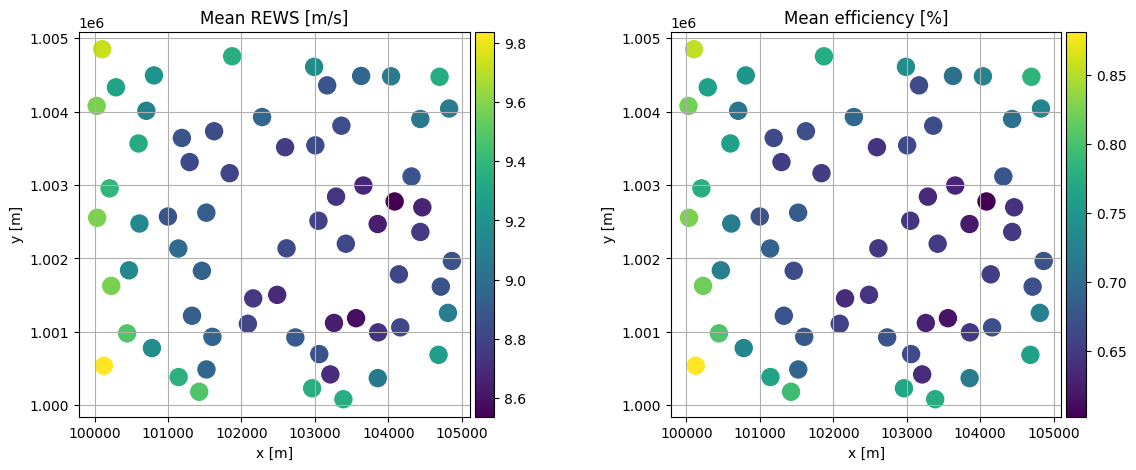

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(
    fig=fig, ax=axs[0], color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0
)
o.get_figure(
    fig=fig,
    ax=axs[1],
    color_by="mean_EFF",
    title="Mean efficiency [%]",
    s=150,
    annotate=0,
)
plt.show()